# Creating the Predictor Model
This is the offical codebase for exploring with what our predictor model will be.This task, as we are predicting a number between 0 and 1, is a regression task.


As a reminder what the pipeline will look like is:
1. LLM receives the prompt from the user, which will be the region that they are in.
2. The model called the predictor model (one or an essemble of the models below) is trained on historical, static data.
3. The RAG architecture will allow the LLM also to gain access to external real-time information -- current fire alerts, weather data, etc.
4. Together with the predictor model score and the RAG information, the LLM will generate its response.


# datasets:
1. https://firms.modaps.eosdis.nasa.gov/map/#d:24hrs;@-78.1,7.3,4.5z

2. https://fireecology.springeropen.com/articles/10.1186/s42408-024-00335-2/tables/2
 --- Archive data: https://www.ncei.noaa.gov/archive

# Imports & downloading local files

In [ ]:
# necessary modules
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import json


We start our exploration of the models using 10 - 15K examples from the following datasets:
1. https://www.kaggle.com/datasets/behroozsohrabi/us-wildfire-records-6th-edition?resource=download
2. vegetation data: local file on github
3. enviromental data: local file on github

load in the local files using the bottom command

In [ ]:
uploaded = files.upload()

Saving meta_estimator_weights.json to meta_estimator_weights.json


In [ ]:
file_path = 'wrc_download_20240522.xlsx'
excel_file = pd.ExcelFile(file_path)

The models we will explore are:
1. Random Forest
2. Decision Trees
3. A sequential neural network
4. An ensemble of these

Result will be structured in the following format:

{hyperparameters}: {accuracy}

For all models besides the Sequential Neural Network which we implement with Keras, we use Scikit-Learn.  

The models chosen were based on the literary review of the following papers:
https://github.com/CS222-UIUC/team-63-project/blob/main/Update.pdf

*We will formally cite the papers at a future date. As we explore, the paper list will expand.*

# Method 1: Random Forest Regression Trees
Summary: A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and chooses the final answer based on majority vote. It also uses averaging to improve the predictive accuracy and control over-fitting.


Documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
```
class sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='squared_error',
max_depth=None,
min_samples_split=2,
min_samples_leaf=1,
min_weight_fraction_leaf=0.0,
max_features=1.0,
max_leaf_nodes=None,
min_impurity_decrease=0.0,
bootstrap=True,
oob_score=False,
n_jobs=None,
random_state=None,
verbose=0,
warm_start=False,
ccp_alpha=0.0,
max_samples=None,
monotonic_cst=None)[source]

```
The most important hyperparameters are 'n_estimators', 'criterion', 'random_state', and 'max_depth'.
* n_estimators: the number of trees in the forest
* random state: Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
* criterion: loss. {“squared_error”, “absolute_error”, “friedman_mse”, “poisson”}, default=”squared_error”.
* max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.




In [ ]:

"""
Notes on hyperparameter:
n_estimators=[start: 90, end: 250, step_size: 10]. We will refine as we explore.
random_state I do not think plays a hugs factor.

random state: I don't think we have to change this --- but we can try with other random numbers

criterion: in addition to defualt -- gini -- we can try entropy.
Gini impurity helps in building classification trees by evaluating the quality of
the splits (or branching points) in the tree, so we may end uyp defaulting to it.

max_depth: this was not a hyper param given. However, we can try with [start: 5, end: 20, step_size: 5]. e will refine as we explore.

"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# file_path = 'wrc_download.xlsx'
# excel_file = pd.ExcelFile(file_path)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5]
}

def visualize_predictions(y_test, y_pred, level_name):
    plt.figure(figsize=(14, 5))

    # Scatter
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel("Actual BP_NATIONAL_RANK")
    plt.ylabel("Predicted")
    plt.title(f"{level_name} - Actual vs Predicted")

    # Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.7, color='green')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"{level_name} - Residual Plot")

    plt.tight_layout()
    plt.show()

def train_rf_model(df, level_name):
    print(f"\n📍 Training model for: {level_name}")

    # Relevant features
    required_cols = [
        'POP', 'TOTAL_BUILDINGS',
        'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE',
        'RISK_NATIONAL_RANK', 'BP_NATIONAL_RANK'
    ]
    df = df[required_cols].dropna()

    X = df.drop(columns='BP_NATIONAL_RANK')
    y = df['BP_NATIONAL_RANK']

    # Split into train (64%), val (16%), test (20%)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    # GridSearch on validation set
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
    grid_search.fit(X_val, y_val)

    print("Best parameters:", grid_search.best_params_)
    print("Best CV score (Neg MSE):", grid_search.best_score_)

    # Retrain best model on training + validation set
    best_rf = grid_search.best_estimator_
    best_rf.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))


    y_pred = best_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Test Set MSE:", mse)
    print("Test Set R² Score:", r2)

    visualize_predictions(y_test, y_pred, level_name)

# Running for each level
state_df = excel_file.parse('States')
county_df = excel_file.parse('Counties')
community_df = excel_file.parse('Communities')

# train_rf_model(state_df, "States")
# train_rf_model(county_df, "Counties")
# train_rf_model(community_df, "Communities")



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# file_path = 'wrc_download.xlsx'
file_path = '/content/wrc_download_20240522.xlsx'
excel_file = pd.ExcelFile(file_path)

#  hyperparameter grid
param_grid = {
    'n_estimators': list(range(90, 260, 10)),
    'max_depth': list(range(5, 25, 5)) + [None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}

# Visualization
def visualize_predictions(y_test, y_pred, level_name):
    plt.figure(figsize=(14, 5))

    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel("Actual BP_NATIONAL_RANK")
    plt.ylabel("Predicted")
    plt.title(f"{level_name} - Actual vs Predicted")

    # Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.7, color='green')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"{level_name} - Residual Plot")

    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, features, level_name):
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [features[i] for i in sorted_idx]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(features)), importances[sorted_idx], align='center')
    plt.yticks(range(len(features)), sorted_features)
    plt.xlabel("Feature Importance")
    plt.title(f"{level_name} - Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


def print_feature_weights(model, features, level_name):
    importances = model.feature_importances_
    print(f"\n📌 Feature Weights for {level_name}:")
    for feature, importance in zip(features, importances):
        print(f"{feature}: {round(importance, 4)}")

def train_rf_model(df, level_name):
    print(f"\n📍 Training model for: {level_name}")


    required_cols = [
        'POP', 'TOTAL_BUILDINGS',
        'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE',
        'RISK_NATIONAL_RANK', 'BP_NATIONAL_RANK'
    ]
    df = df[required_cols].dropna()

    X = df.drop(columns='BP_NATIONAL_RANK')
    y = df['BP_NATIONAL_RANK']

    # Train/validation/test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    # Grid search on validation
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
    grid_search.fit(X_val, y_val)

    print("Best parameters:", grid_search.best_params_)
    print("Best CV score (Neg MSE):", grid_search.best_score_)


    best_rf = grid_search.best_estimator_
    best_rf.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))


    y_pred = best_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(" Test Set MSE:", round(mse, 2))
    print(" Test Set R² Score:", round(r2, 3))
    print(" Test Set MAE:", round(mae, 2))

    visualize_predictions(y_test, y_pred, level_name)
    plot_feature_importance(best_rf, list(X.columns), level_name)
    print_feature_weights(best_rf, list(X.columns), level_name)

# Running for each level
state_df = excel_file.parse('States')
county_df = excel_file.parse('Counties')
community_df = excel_file.parse('Communities')

train_rf_model(state_df, "States")
train_rf_model(county_df, "Counties")
train_rf_model(community_df, "Communities")


Final Random Forests model


📍 Training model for: States
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'n_estimators': 110, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'absolute_error'}
Best CV score (Neg MSE): -0.07675981634527078
Test Set MSE: 0.0028
Test Set R² Score: 0.9553
Test Set MAE: 0.0469


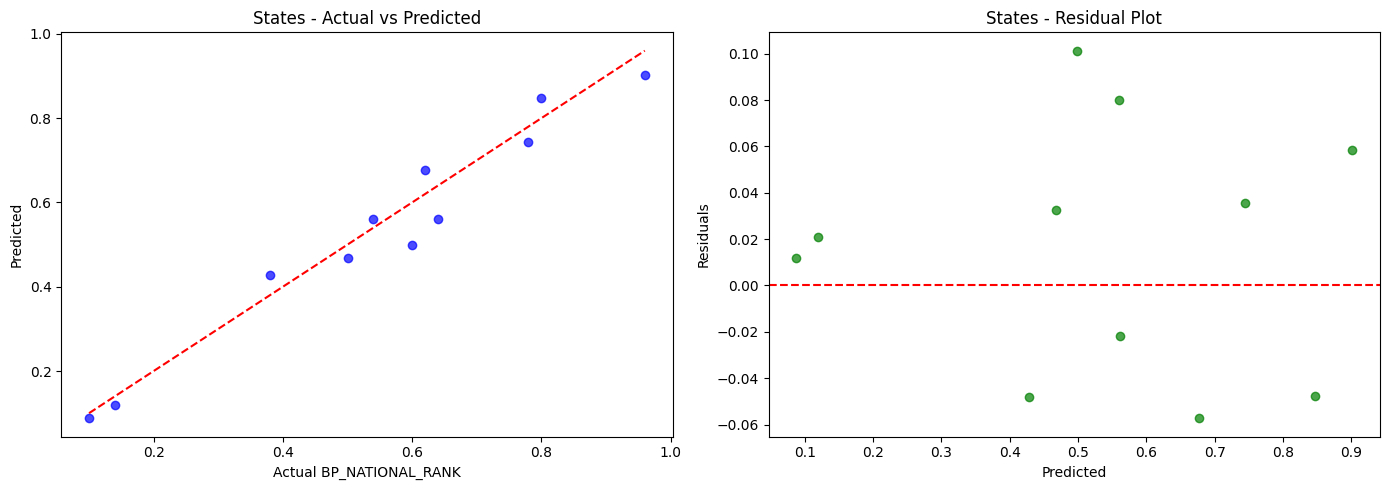

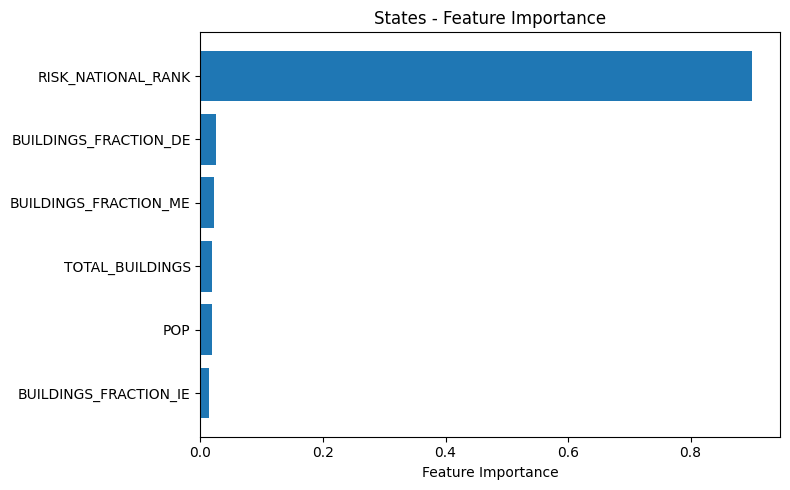


📌 Feature Weights for States:
POP: 0.0186
TOTAL_BUILDINGS: 0.0189
BUILDINGS_FRACTION_ME: 0.0219
BUILDINGS_FRACTION_IE: 0.0145
BUILDINGS_FRACTION_DE: 0.0252
RISK_NATIONAL_RANK: 0.9009

🔍 SHAP Summary for States


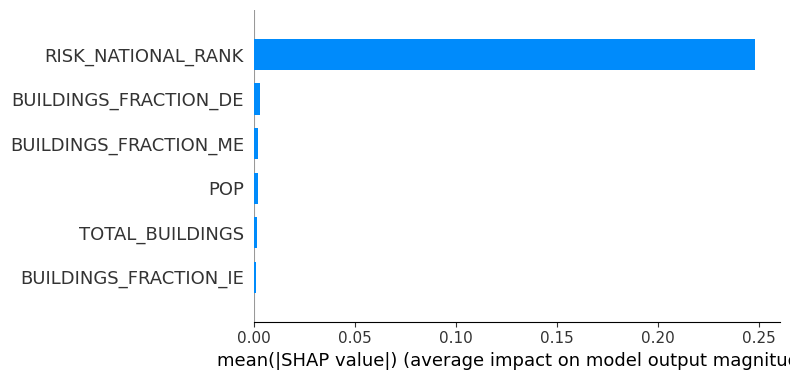

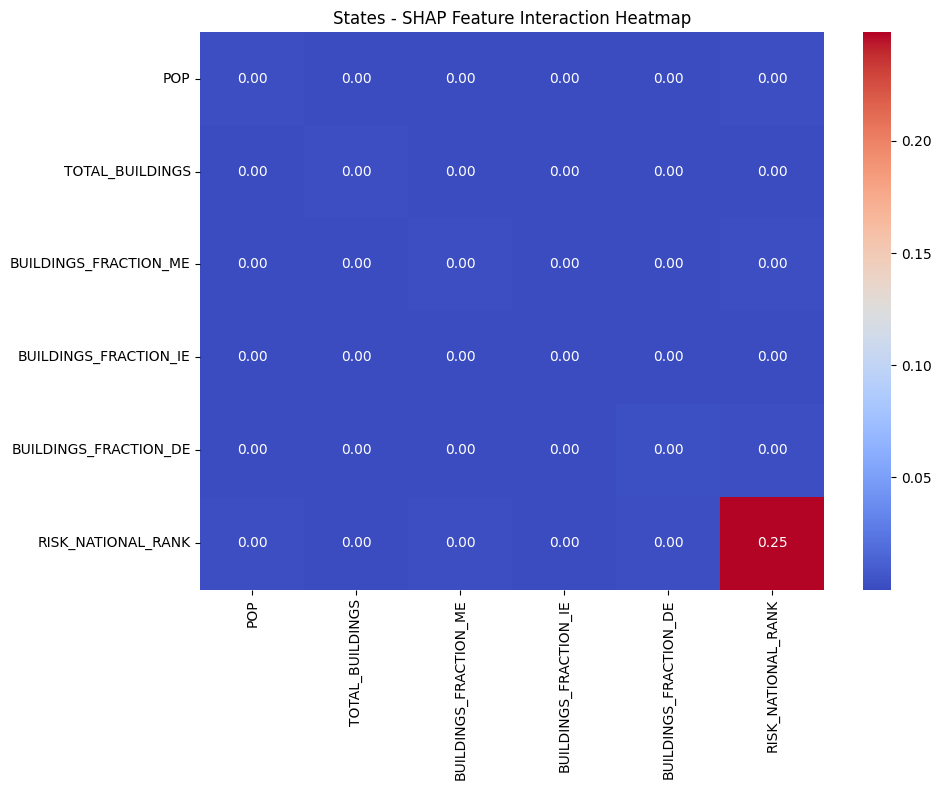


📍 Training model for: Counties
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'n_estimators': 220, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'squared_error'}
Best CV score (Neg MSE): -0.000729713060324922
Test Set MSE: 0.0007
Test Set R² Score: 0.9912
Test Set MAE: 0.0181


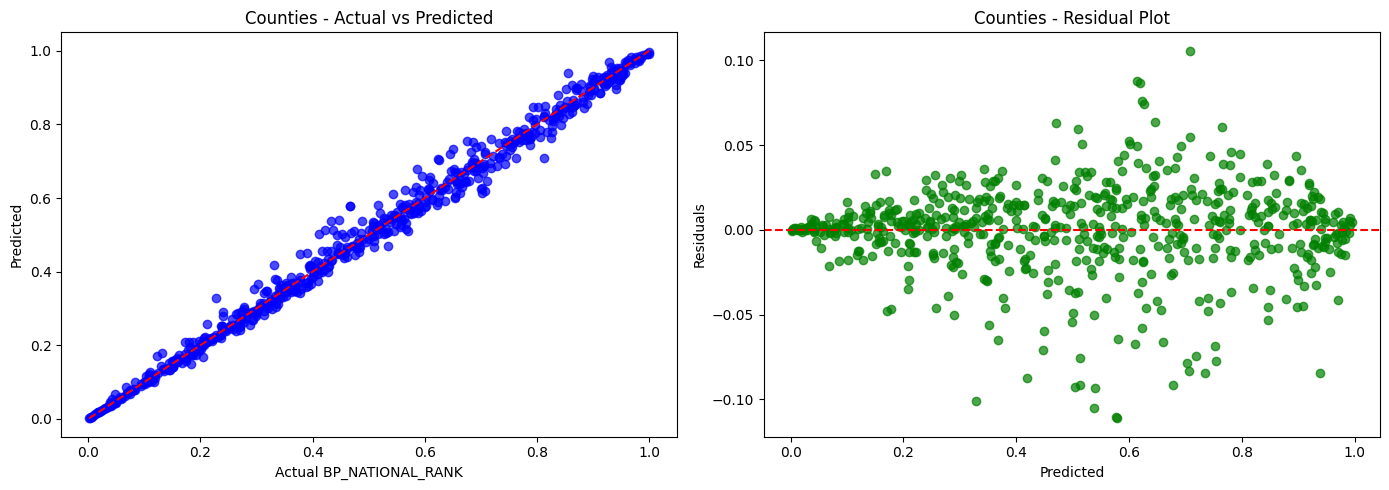

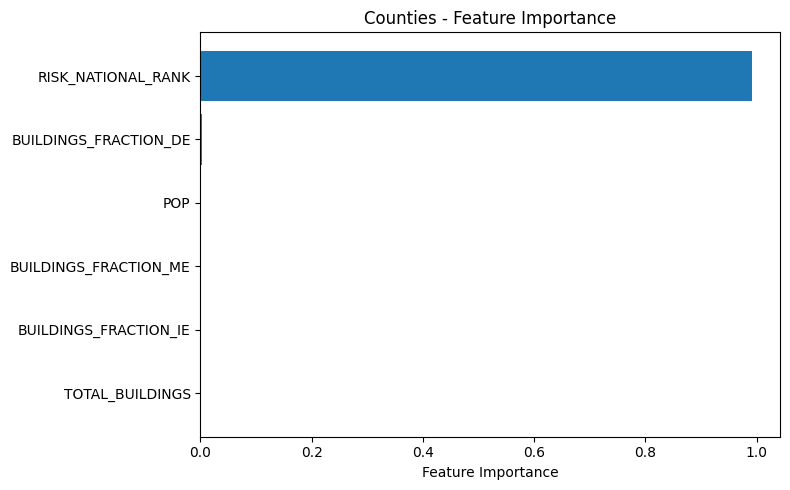


📌 Feature Weights for Counties:
POP: 0.0016
TOTAL_BUILDINGS: 0.0011
BUILDINGS_FRACTION_ME: 0.0013
BUILDINGS_FRACTION_IE: 0.0012
BUILDINGS_FRACTION_DE: 0.0024
RISK_NATIONAL_RANK: 0.9924

🔍 SHAP Summary for Counties


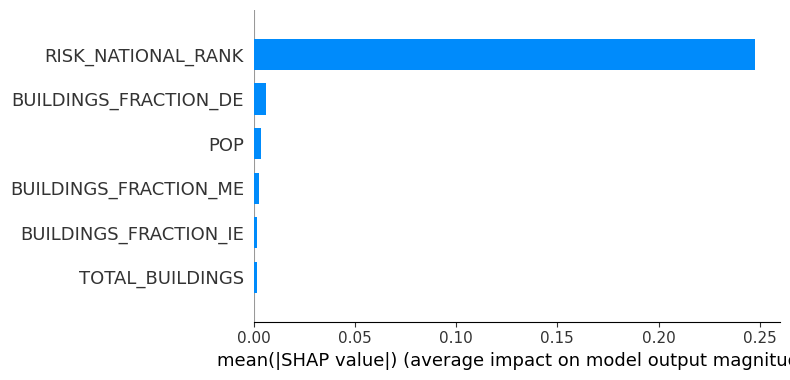

In [ ]:

file_path = 'wrc_download.xlsx'
excel_file = pd.ExcelFile(file_path)

# hyperparameter grid
param_grid = {
    'n_estimators': list(range(90, 260, 10)),
    'max_depth': list(range(5, 25, 5)) + [None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}



# Visualization
def visualize_predictions(y_test, y_pred, level_name):
    plt.figure(figsize=(14, 5))

    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel("Actual BP_NATIONAL_RANK")
    plt.ylabel("Predicted")
    plt.title(f"{level_name} - Actual vs Predicted")

    # Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.7, color='green')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"{level_name} - Residual Plot")

    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, features, level_name):
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [features[i] for i in sorted_idx]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(features)), importances[sorted_idx], align='center')
    plt.yticks(range(len(features)), sorted_features)
    plt.xlabel("Feature Importance")
    plt.title(f"{level_name} - Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

#SHAP Visualizations
def plot_shap_summary(model, X, level_name):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    print(f"\n🔍 SHAP Summary for {level_name}")
    shap.summary_plot(shap_values, X, plot_type="bar")

def plot_shap_interaction_heatmap(model, X, level_name):
    explainer = shap.TreeExplainer(model)
    interaction_values = explainer.shap_interaction_values(X)

    mean_interactions = np.abs(interaction_values).mean(0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(mean_interactions, xticklabels=X.columns, yticklabels=X.columns,
                cmap='coolwarm', annot=True, fmt=".2f")
    plt.title(f"{level_name} - SHAP Feature Interaction Heatmap")
    plt.tight_layout()
    plt.show()


def print_feature_weights(model, features, level_name):
    importances = model.feature_importances_
    print(f"\n📌 Feature Weights for {level_name}:")
    for feature, importance in zip(features, importances):
        print(f"{feature}: {round(importance, 4)}")


def train_rf_model(df, level_name):
    print(f"\n📍 Training model for: {level_name}")

    # Feature selection
    required_cols = [
        'POP', 'TOTAL_BUILDINGS',
        'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE',
        'RISK_NATIONAL_RANK', 'BP_NATIONAL_RANK'
    ]
    df = df[required_cols].dropna()

    X = df.drop(columns='BP_NATIONAL_RANK')
    y = df['BP_NATIONAL_RANK']

    # Split into train (64%), val (16%), test (20%)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    # Grid search on validation
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
    grid_search.fit(X_val, y_val)

    print("Best parameters:", grid_search.best_params_)
    print("Best CV score (Neg MSE):", grid_search.best_score_)

    # Retrain on train+val with best params
    best_rf = grid_search.best_estimator_
    best_rf.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

    # Predict on test set
    y_pred = best_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print("Test Set MSE:", round(mse, 4))
    print("Test Set R² Score:", round(r2, 4))
    print("Test Set MAE:", round(mae, 4))

    visualize_predictions(y_test, y_pred, level_name)
    plot_feature_importance(best_rf, list(X.columns), level_name)
    print_feature_weights(best_rf, list(X.columns), level_name)
    plot_shap_summary(best_rf, X, level_name)
    plot_shap_interaction_heatmap(best_rf, X, level_name)

    return best_rf, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), X_test, y_test


state_df = excel_file.parse('States')
county_df = excel_file.parse('Counties')
community_df = excel_file.parse('Communities')

# Train base Random Forest models
model_states, X_train_states, y_train_states, X_test, y_test = train_rf_model(state_df, "States")
model_counties, X_train_counties, y_train_counties, _, _ = train_rf_model(county_df, "Counties")
model_communities, X_train_communities, y_train_communities, _, _ = train_rf_model(community_df, "Communities")

# Saving these models
with open('rf_model_states.pkl', 'wb') as f:
    pickle.dump(model_states, f)

with open('rf_model_counties.pkl', 'wb') as f:
    pickle.dump(model_counties, f)

with open('rf_model_communities.pkl', 'wb') as f:
    pickle.dump(model_communities, f)


base_estimators = [
    ('states_rf', model_states),
    ('counties_rf', model_counties),
    ('communities_rf', model_communities)
]

# Meta-learner
meta_model = LinearRegression()

# Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_model
)

# Training stacking ensemble
stacking_regressor.fit(X_train_states, y_train_states)

# Predict using stacking model
y_pred_stacked = stacking_regressor.predict(X_test)

# Evaluating ensemble
mse_stacked = mean_squared_error(y_test, y_pred_stacked)
r2_stacked = r2_score(y_test, y_pred_stacked)
mae_stacked = mean_absolute_error(y_test, y_pred_stacked)

print("\n Stacking Ensemble Results:")
print("Test Set MSE:", round(mse_stacked, 4))
print("Test Set R² Score:", round(r2_stacked, 4))
print("Test Set MAE:", round(mae_stacked, 4))

#Saving the ensemble model
with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_regressor, f)
print("\n Model saved as 'stacking_model.pkl'")


Try Kinjal's LR method

In [ ]:
#counties:
# Best parameters: {'n_estimators': 220, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'squared_error'}
rf_counties = RandomForestRegressor(n_estimators = 220, min_samples_split = 5, min_samples_leaf = 1, max_features = None, max_depth = None, criterion = 'squared_error', random_state=42)

#communities
# Best parameters: {' ': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15, 'criterion': 'absolute_error'}
rf_communities = RandomForestRegressor(n_estimators = 150, min_samples_split = 5, min_samples_leaf = 2, max_features = None, max_depth = 15, criterion = 'absolute_error', random_state=42)

rf_states = RandomForestRegressor(n_estimators= 110, min_samples_split= 2, min_samples_leaf= 1, max_features= None, max_depth= 10, criterion= 'absolute_error')


In [ ]:
import keras
model_nn_com = keras.saving.load_model('/content/Community_model_weights.keras')
model_nn_coun = keras.saving.load_model('/content/County_model_weights.keras')
model_rf_com = rf_counties
model_rf_coun = rf_communities

# Method 4: Sequential Neural Network
* this can be implemented in both pytorch or keras. I decided to just use keras since there is no need to implement everything from scratch. That is a good excerise if one wants to do it, however, and one I would recommend.

Summary: a sequential neural network is a neural network that specializes in sequences as data is passed linearly.

Documentation: https://keras.io/guides/sequential_model/

Counties:
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.3512 - mae: 0.5265 - val_loss: 2.0908 - val_mae: 0.4112 - learning_rate: 1.0000e-04
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0459 - mae: 0.4000 - val_loss: 1.8623 - val_mae: 0.3276 - learning_rate: 1.0000e-04
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8347 - mae: 0.3153 - val_loss: 1.6741 - val_mae: 0.2631 - learning_rate: 1.0000e-04
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6586 - mae: 0.2671 - val_loss: 1.5223 - val_mae: 0.2336 - learning_rate: 1.0000e-04
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5115 - mae: 0.2485 - val_loss: 1.3931 - val_mae: 0.2256 - learning_rate: 1.0000e-04
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3771 - mae: 0.2482 - val_loss: 1.2754 - val_mae: 0.2212 - learning_rate: 1.0000e-04
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2639 - mae: 0.2491 - val_loss: 1.1682 - val_mae: 0.2198 - learning_rate: 1.0000e-

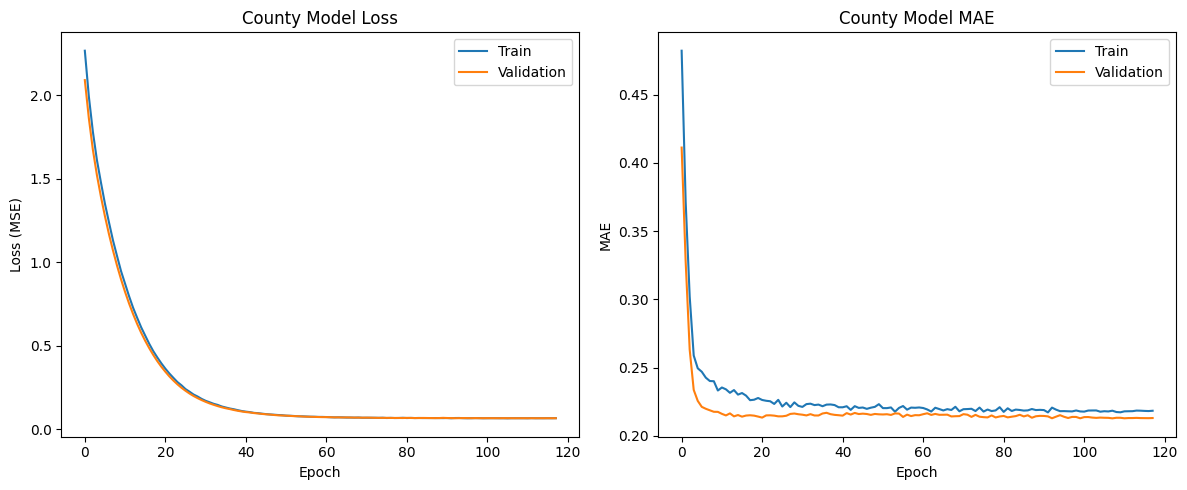

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

def sequential(df, level_name):
    # Preprocessing
    required_cols = [
        'POP', 'TOTAL_BUILDINGS',
        'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE',
        'BP_NATIONAL_RANK'
    ]
    df = df[required_cols].dropna()

    X = df.drop(columns='BP_NATIONAL_RANK')
    y = df['BP_NATIONAL_RANK']

    # Train/val/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Model architecture
    model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),  # Randomly drop 20% of units
    Dense(32, activation='relu', kernel_regularizer=l2(0.05)),
    # Dropout(0.2),
    # Dense(16, activation='relu'),
    # Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
    ])
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )

    # Callbacks
    log_dir = os.path.join("logs", level_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    os.makedirs(log_dir, exist_ok=True)

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Training
    sample_weight = compute_sample_weight('balanced', y_train)
    history = model.fit(
        X_train, y_train,
        sample_weight=sample_weight,
        epochs=200,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, reduce_lr, tensorboard_callback],
        verbose=1
    )

    # Evaluation
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n{level_name} Test MSE: {test_loss:.2f}, MAE: {test_mae:.2f}")

    # ====== PLOTTING ======
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{level_name} Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title(f'{level_name} Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig(f'{level_name}_training_curves.png')
    plt.show()

    # Save model
    model.save(f"{level_name}_model_weights.keras")
    return model, scaler, history

# Run with plotting
print("Counties:")
county_model, county_scaler, county_history = sequential(county_df, "County")

Using the same weights resulted in the validation loss being typically smaller than the training loss, which indicated that the model was underfitting on the training dataset. Thus, I knew I needed a different model for Community. I guess this could make sense because different zones can have different risks to fire, so having one unified model, expecially if we are using nueral networks, would not make too much sense.

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


963/963 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.8749 - mae: 0.3877 - val_loss: 0.8940 - val_mae: 0.2259 - learning_rate: 1.0000e-04
Epoch 2/200
963/963 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.7656 - mae: 0.2348 - val_loss: 0.4389 - val_mae: 0.2209 - learning_rate: 1.0000e-04
Epoch 3/200
963/963 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3903 - mae: 0.2256 - val_loss: 0.2568 - val_mae: 0.2199 - learning_rate: 1.0000e-04
Epoch 4/200
963/963 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2392 - mae: 0.2242 - val_loss: 0.1805 - val_mae: 0.2191 - learning_rate: 1.0000e-04
Epoch 5/200
963/963 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1705 - mae: 0.2226 - val_loss: 0.1362 - val_mae: 0.2187 - learning_rate: 1.0000e-04
Epoch 6/200
963/963 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1297 - mae: 0.2190 - val_loss: 0.1077 - val_mae: 0.2194 - learning_rate: 1.0000e-04
Epoch 7/200
963/963 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1046 - mae: 0.2212 - val_loss: 0.0883 - val_mae: 0.2186 - learning_

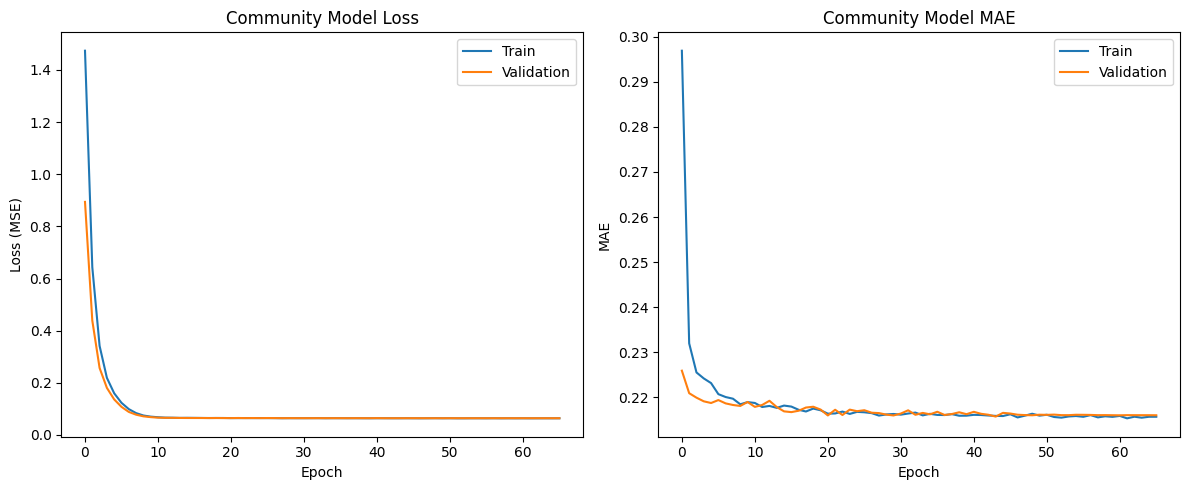

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

df = community_df
level_name = "Community"
# Preprocessing
required_cols = [
    'POP', 'TOTAL_BUILDINGS',
    'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE',
    'BP_NATIONAL_RANK'
]
df = df[required_cols].dropna()

X = df.drop(columns='BP_NATIONAL_RANK')
y = df['BP_NATIONAL_RANK']

# Train/val/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Model architecture
model = Sequential([
Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
Dropout(0.2),  # Randomly drop 20% of units
Dense(32, activation='relu', kernel_regularizer=l2(0.05)),
Dropout(0.2),
Dense(16, activation='relu'),
Dense(1, activation='linear')
])
# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae']
)

# Callbacks
log_dir = os.path.join("logs", level_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training
sample_weight = compute_sample_weight('balanced', y_train)
history = model.fit(
    X_train, y_train,
    sample_weight=sample_weight,
    epochs=200,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, tensorboard_callback],
    verbose=1
)

# Evaluation
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\n{level_name} Test MSE: {test_loss:.2f}, MAE: {test_mae:.2f}")

# ====== PLOTTING ======
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'{level_name} Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title(f'{level_name} Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig(f'{level_name}_training_curves.png')
plt.show()

# Save model
model.save(f"{level_name}_model_weights.keras")



Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - loss: 1.9093 - mae: 0.7684 - val_loss: 2.6584 - val_mae: 1.1311 - learning_rate: 1.0000e-04
Epoch 2/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 1.8735 - mae: 0.7379 - val_loss: 2.6420 - val_mae: 1.1256 - learning_rate: 1.0000e-04
Epoch 3/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 1.9076 - mae: 0.7764 - val_loss: 2.6257 - val_mae: 1.1200 - learning_rate: 1.0000e-04
Epoch 4/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 2.0647 - mae: 0.8225 - val_loss: 2.6096 - val_mae: 1.1146 - learning_rate: 1.0000e-04
Epoch 5/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 1.9931 - mae: 0.7707 - val_loss: 2.5943 - val_mae: 1.1094 - learning_rate: 1.0000e-04
Epoch 6/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 2.0425 - mae: 0.8139 - val_loss: 2.5794 - val_mae: 1.1043 - learning_rate: 1.0000e-04
Epoch 7/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 2.0498 - mae: 0.8267 - val_loss: 2.5650 - val_mae: 1.0993 - learning_rate: 1.0000e-04
Epo

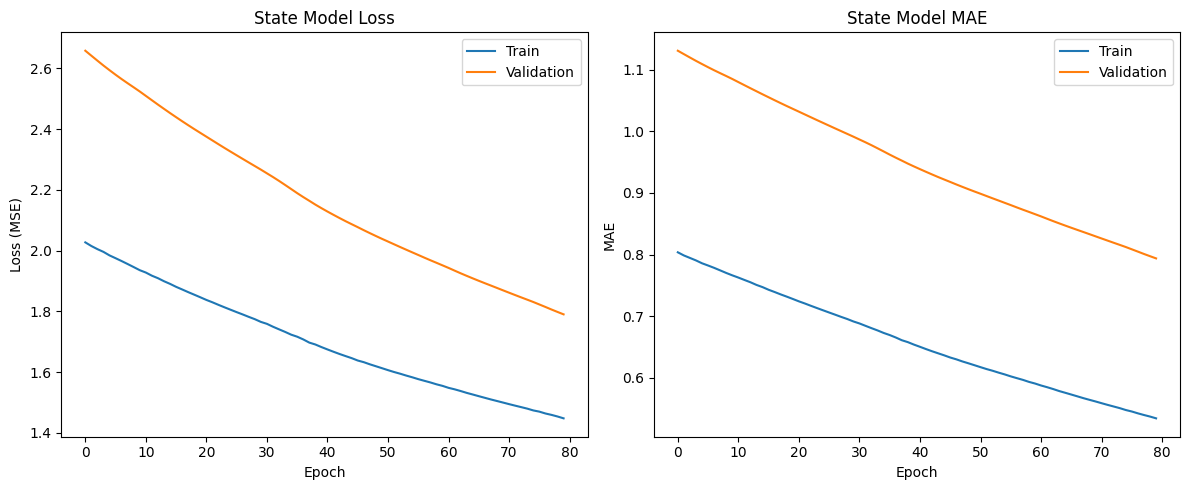

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

df = state_df
level_name = "State"
# Preprocessing
required_cols = [
    'POP', 'TOTAL_BUILDINGS',
    'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE',
    'BP_NATIONAL_RANK'
]
df = df[required_cols].dropna()

X = df.drop(columns='BP_NATIONAL_RANK')
y = df['BP_NATIONAL_RANK']

# Train/val/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# grid

# Model architecture
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    # Dense(16, activation='relu', kernel_regularizer=l2(0.05)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.05)),
    Dense(1, activation='linear')
    ])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae']
)

# Callbacks
log_dir = os.path.join("logs", level_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training
sample_weight = compute_sample_weight('balanced', y_train)
history = model.fit(
    X_train, y_train,
    sample_weight=sample_weight,
    epochs=80,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, tensorboard_callback],
    verbose=1
)

# Evaluation
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\n{level_name} Test MSE: {test_loss:.2f}, MAE: {test_mae:.2f}")

# ====== PLOTTING ======
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'{level_name} Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title(f'{level_name} Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig(f'{level_name}_training_curves.png')
plt.show()

# Save model
model.save(f"{level_name}_model_weights.keras")



For some reason, better looking curves result in higher MSE and MAE.

Anyway, below is a survey of some model architecures and learning curves I obtained:

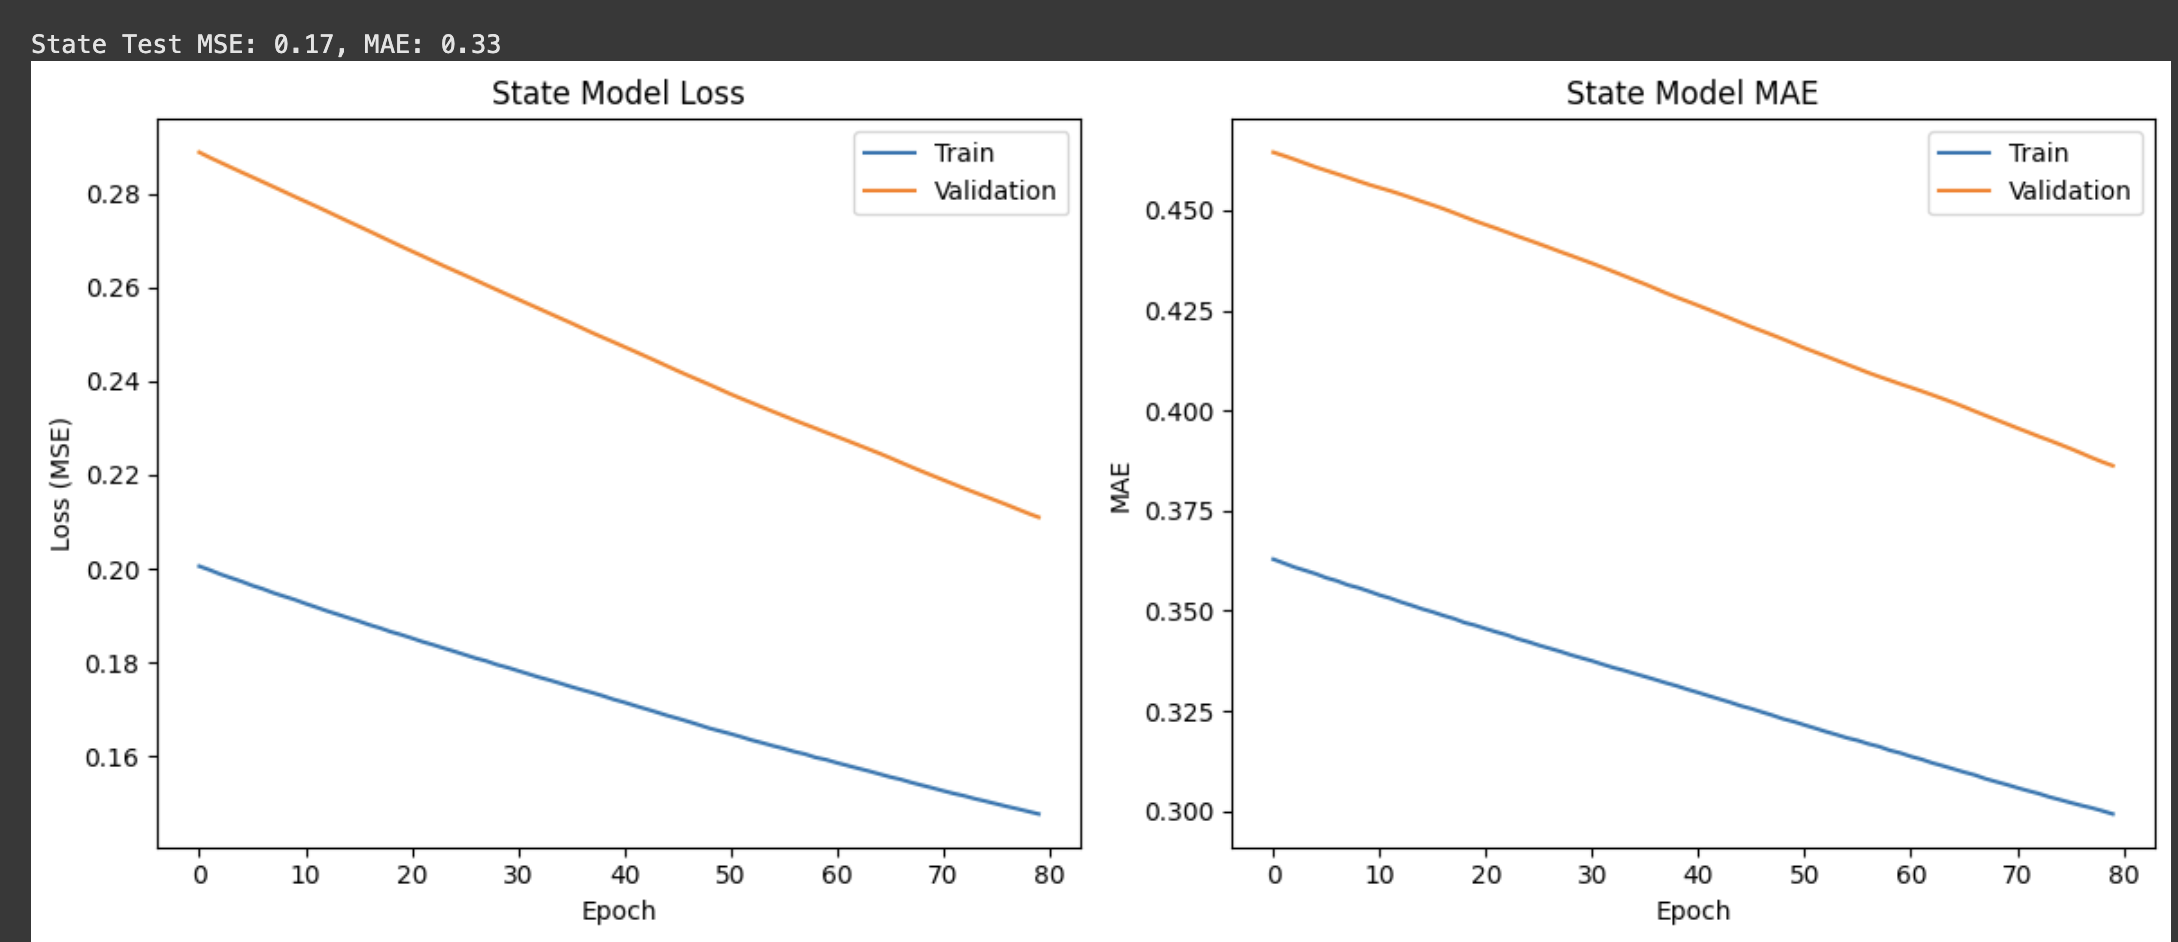

This is the best MSE I can get, but the learning curves are not at all what we want to see: very large gap and not comparable performance. This had the model architecture:


```
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='linear')
    ])
```


Strangley enough, as indicated below again, lower MSE and MAE resulted in worse learning curves:


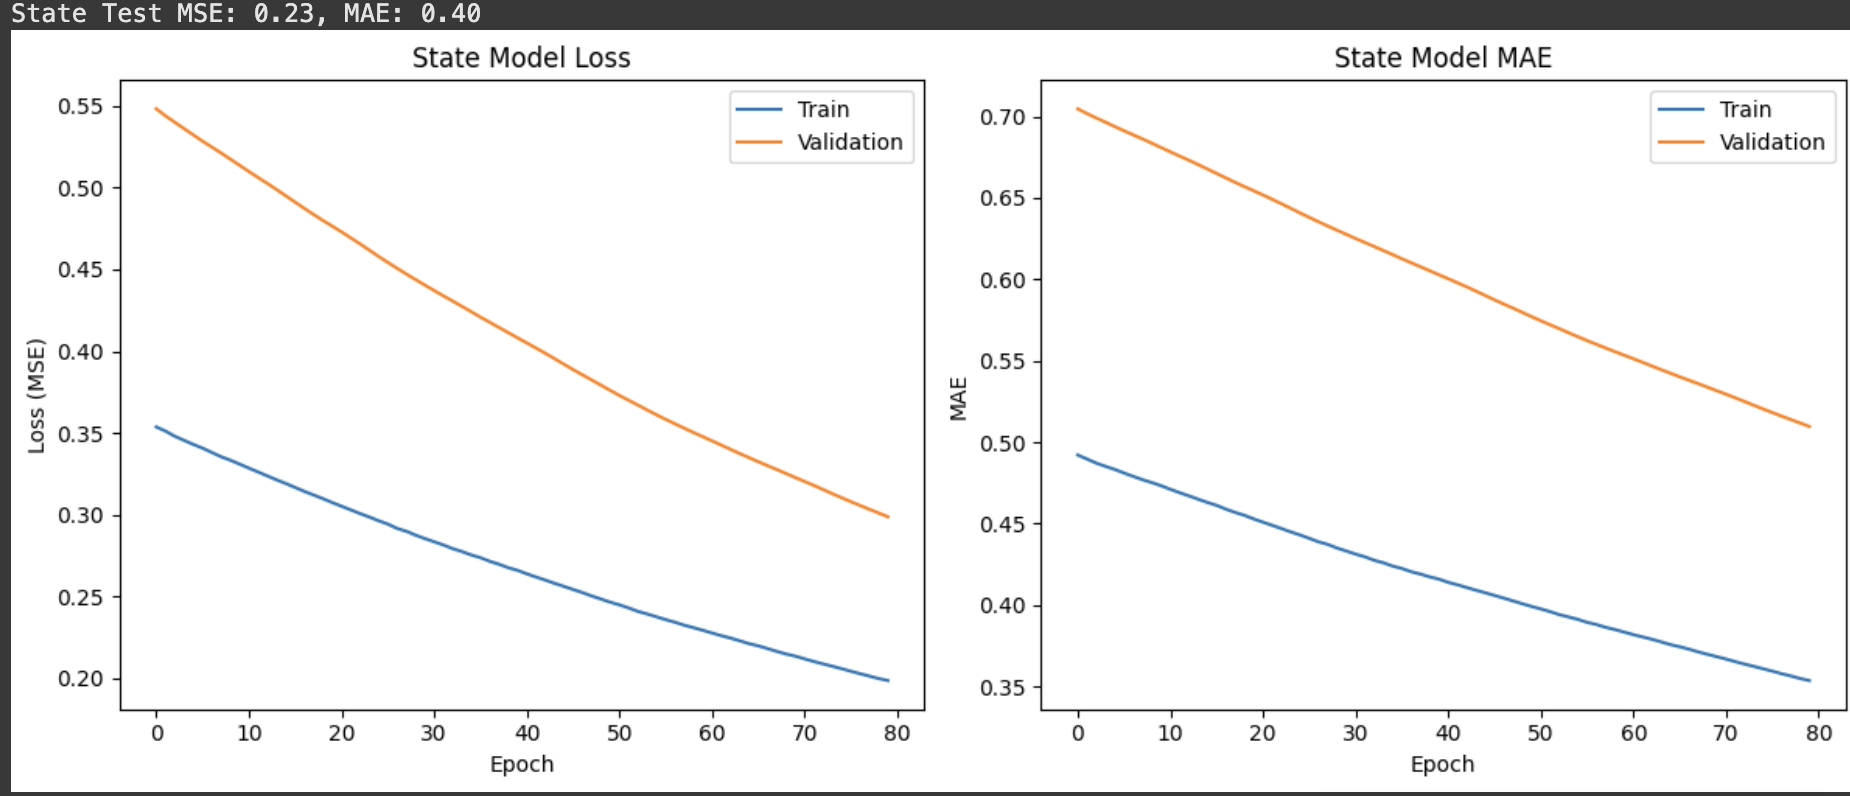

Here are some additional learning curves. At one point, the validation ended up doing much better than training:


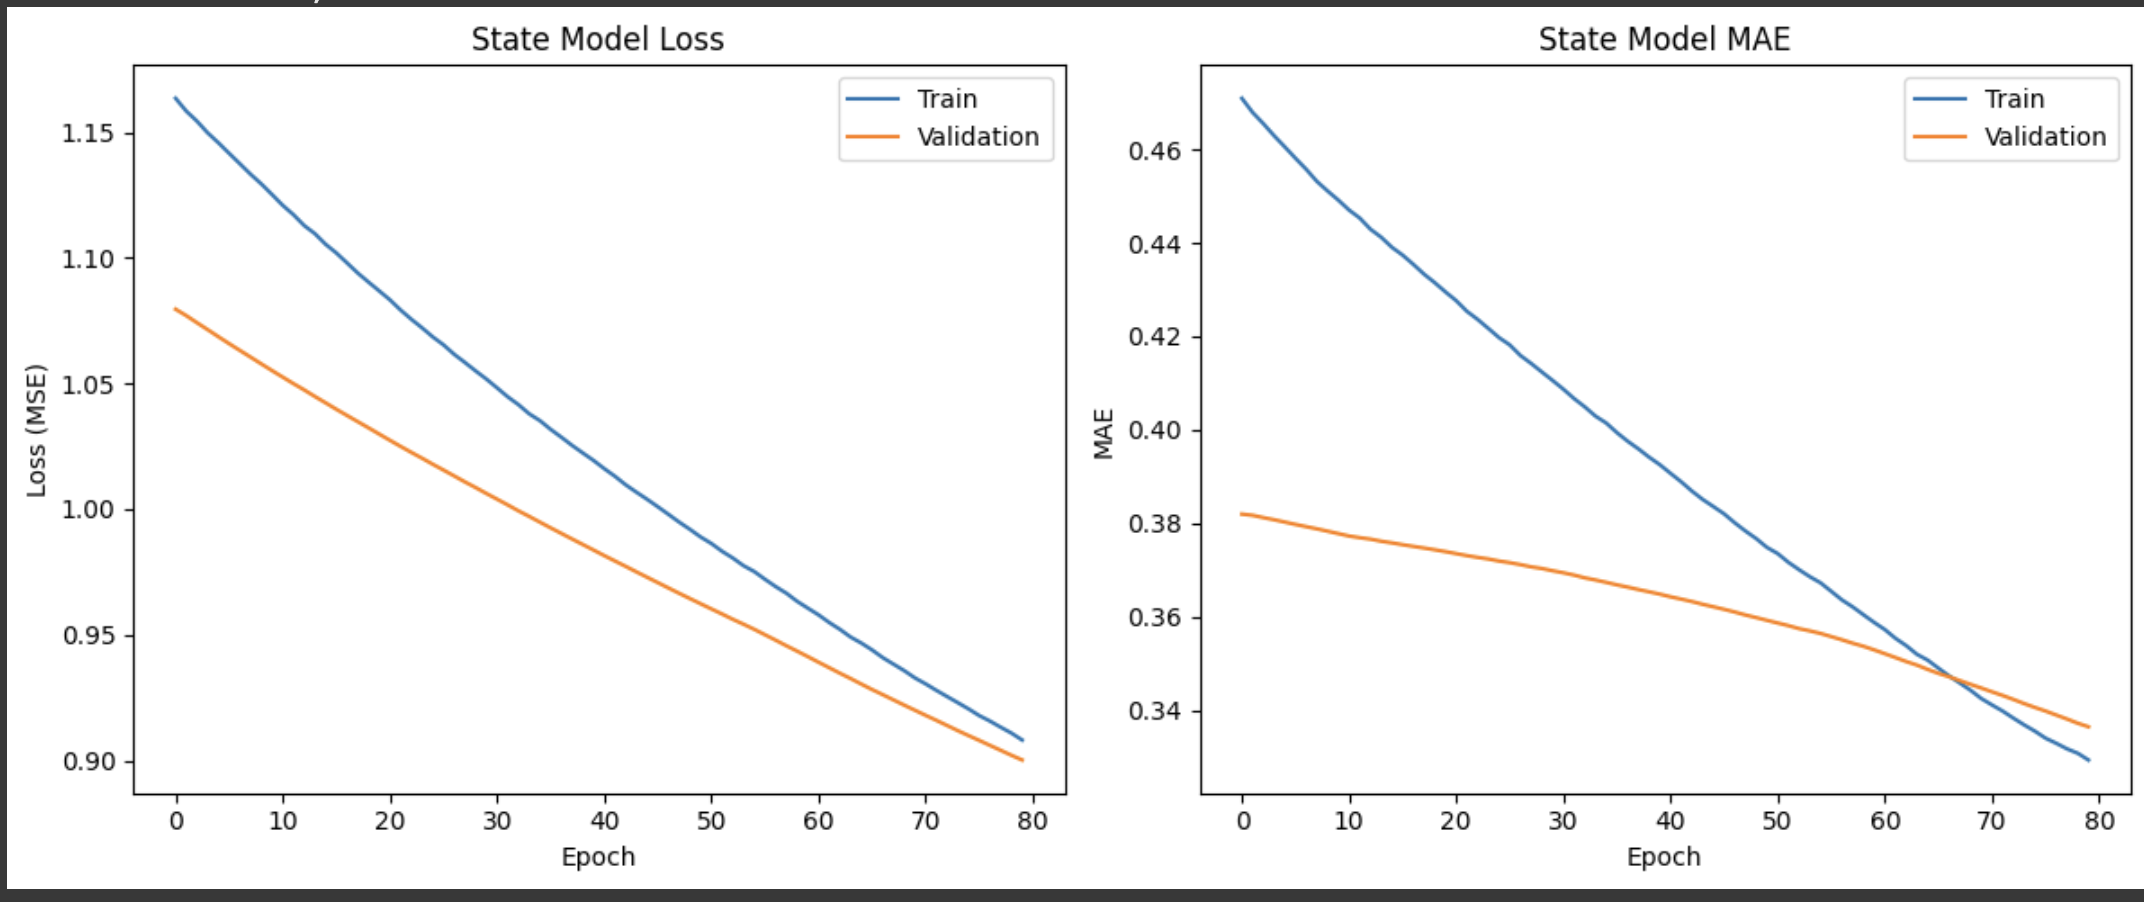

This was with architecture:



```
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.05)),
    Dense(1, activation='linear')
    ])
```


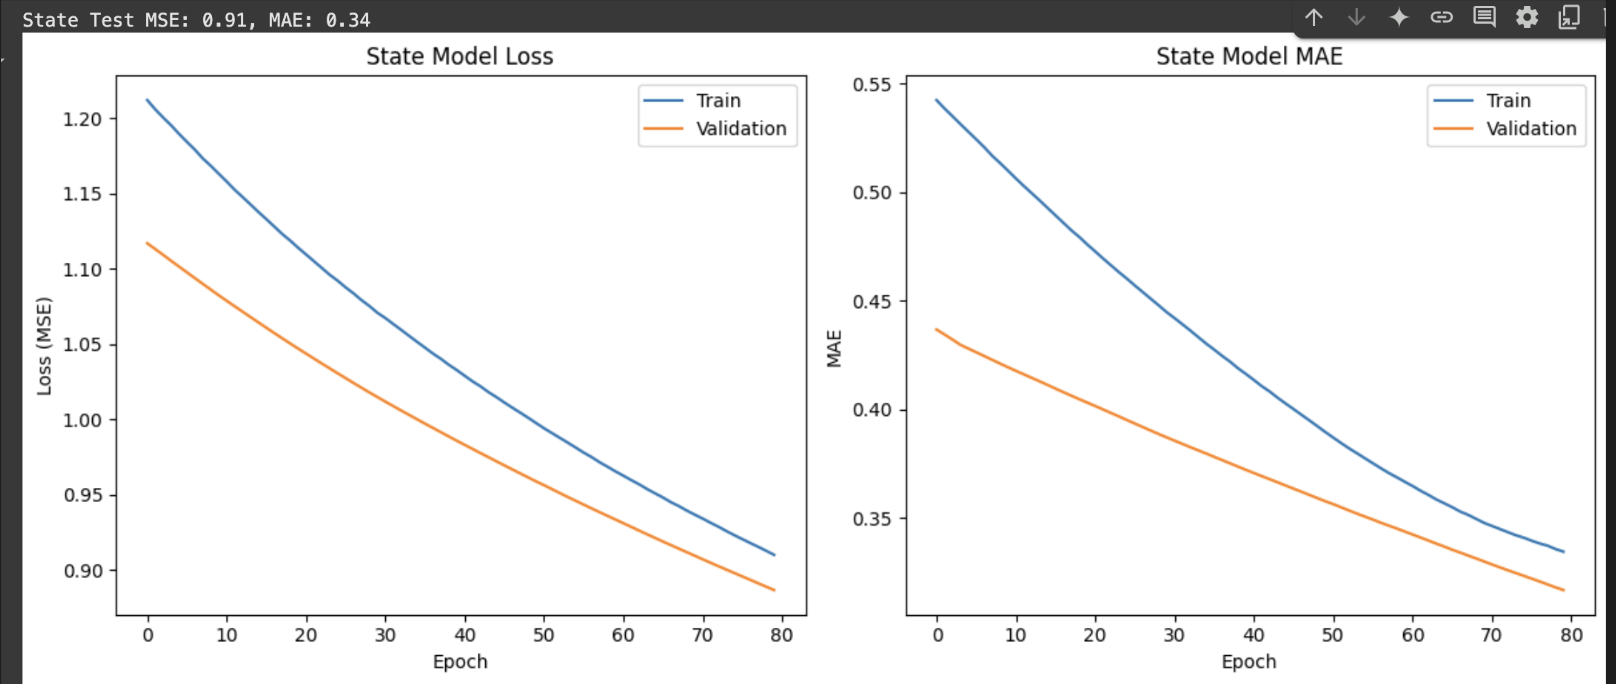

And this was with

```
model = Sequential([
    Dense(18, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.05)),
    Dense(1, activation='linear')
    ])
```




All this to say is that the nueral network is unstable for the states dataset, which is why I recomend we just use the Random Forest for state risk prediction. Luckily, most users will, in general, give specific regions rather than an entire state, so one predictor should be fine.

# Ensemble Apporach

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import keras

In [ ]:
state_df = excel_file.parse('States')
county_df = excel_file.parse('Counties')
community_df = excel_file.parse('Communities')

In [ ]:
def get_splits(df):
    required_cols = [
        'POP', 'TOTAL_BUILDINGS',
        'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE',
        'BP_NATIONAL_RANK'
    ]
    df = df[required_cols].dropna()

    X = df.drop(columns='BP_NATIONAL_RANK')
    y = df['BP_NATIONAL_RANK']

    # Train/val/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

county_df = excel_file.parse('Counties')
community_df = excel_file.parse('Communities')

X_train_com, X_val_com, X_test_com, y_train_com, y_val_com, y_test_com, scalar_com = get_splits(county_df)
X_train_coun, X_val_coun, X_test_coun, y_train_coun, y_val_coun, y_test_coun, scalar_coun = get_splits(community_df)
X_train_states, X_val_states, X_test_states, y_train_states, y_val_states, y_test_states, scalar_states = get_splits(state_df)

In [ ]:
# Best parameters: {'n_estimators': 220, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'squared_error'}
rf_counties = RandomForestRegressor(n_estimators = 220, min_samples_split = 5, min_samples_leaf = 1, max_features = None, max_depth = None, criterion = 'squared_error', random_state=42)

#communities
# Best parameters: {' ': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15, 'criterion': 'absolute_error'}
rf_communities = RandomForestRegressor(n_estimators = 150, min_samples_split = 5, min_samples_leaf = 2, max_features = None, max_depth = 15, criterion = 'absolute_error', random_state=42)

rf_states = RandomForestRegressor(n_estimators= 110, min_samples_split= 2, min_samples_leaf= 1, max_features= None, max_depth= 10, criterion= 'absolute_error')


In [ ]:
# Saving these models
with open('rf_model_states.pkl', 'wb') as f:
    pickle.dump(rf_states, f)

with open('rf_model_counties.pkl', 'wb') as f:
    pickle.dump(rf_counties, f)

with open('rf_model_communities.pkl', 'wb') as f:
    pickle.dump(rf_communities, f)

In [ ]:
model_nn_com = keras.saving.load_model('/content/Community_model_weights.keras')
model_nn_coun = keras.saving.load_model('/content/County_model_weights.keras')
with open('/content/rf_model_states.pkl', 'rb') as f:
    rf_states = pickle.load(f)
with open('/content/rf_model_counties.pkl', 'rb') as f:
    model_rf_coun = pickle.load(f)
with open('/content/rf_model_communities.pkl', 'rb') as f:
    model_rf_com = pickle.load(f)

In [ ]:
import numpy as np
weights = [(w, 1 - w) for w in np.arange(0.1, 0.97, 0.05)]

# for counties
nn_preds_com = model_nn_com.predict(X_test_com).ravel()
model_rf_com.fit(X_train_com, y_train_com)
rf_preds_com = model_rf_com.predict(X_test_com).ravel()

# for communities
nn_preds_coun = model_nn_coun.predict(X_test_coun).ravel()
model_rf_coun.fit(X_train_coun, y_train_coun)
rf_preds_coun = model_rf_coun.predict(X_test_coun).ravel()

best_com_weights = []
best_com_mse= float("inf")
print("---------------------------------------- COMMUNITIES ------------------------------")
for weight_1, weight_2 in weights:
  print("trying weights: ", weight_1, weight_2)
  combined_preds_com = weight_1 * nn_preds_com + weight_2 * rf_preds_com
  tes_mse = mean_squared_error(y_test_com, combined_preds_com)
  if tes_mse < best_com_mse:
    best_com_mse = tes_mse
    best_com_weights = [weight_1, weight_2]

print("---------------------------------------- COUNTIES ------------------------------")
best_coun_weights = []
best_coun_mse = float("inf")
for weight_1, weight_2 in weights:
  print("trying weights: ", weight_1, weight_2)
  combined_preds_mse = weight_1 * nn_preds_coun + weight_2 * rf_preds_coun
  # test_loss = np.mean(np.abs(combined_preds_coun - y_test_coun))
  test_mse = mean_squared_error(y_test_coun, combined_preds_mse)
  if test_mse < best_coun_mse:
    best_coun_mse = test_mse
    best_coun_weights = [weight_1, weight_2]

print("for community best weighting is: " + str(best_com_weights))
print("for counties best weighting is: " + str(best_coun_weights))
print("for community best loss is: " + str(best_com_mse))
print("for counties best loss is: " + str(best_coun_mse))

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
---------------------------------------- COMMUNITIES ------------------------------
trying weights:  0.1 0.9
trying weights:  0.15000000000000002 0.85
trying weights:  0.20000000000000004 0.7999999999999999
trying weights:  0.25000000000000006 0.75
trying weights:  0.30000000000000004 0.7
trying weights:  0.3500000000000001 0.6499999999999999
trying weights:  0.40000000000000013 0.5999999999999999
trying weights:  0.45000000000000007 0.5499999999999999
trying weights:  0.5000000000000001 0.4999999999999999
trying weights:  0.5500000000000002 0.44999999999999984
trying weights:  0.6000000000000002 0.3999999999999998
trying weights:  0.6500000000000001 0.34999999999999987
trying weights:  0.7000000000000002 0.2999999999999998
trying weights:  0.7500000000000002 0.24999999999999978
trying weights:  0.8000000000000002 0.19999999999999984
trying weights:  0.8500000000000002 0.1499999999999998
trying weights:  0

#plot predictions vs actual

In [ ]:
print("mse of nn_com: ", mean_squared_error(y_test_com, nn_preds_com))
print("mse of rf_com: ", mean_squared_error(y_test_com, rf_preds_com))
print("mse of nn_coun: ", mean_squared_error(y_test_coun, nn_preds_coun))
print("mse of rf_coun: ", mean_squared_error(y_test_coun, rf_preds_coun))

mse of nn_com:  0.07265732585957732
mse of rf_com:  0.06902719632748643
mse of nn_coun:  0.06862721844070882
mse of rf_coun:  0.06223099508647185


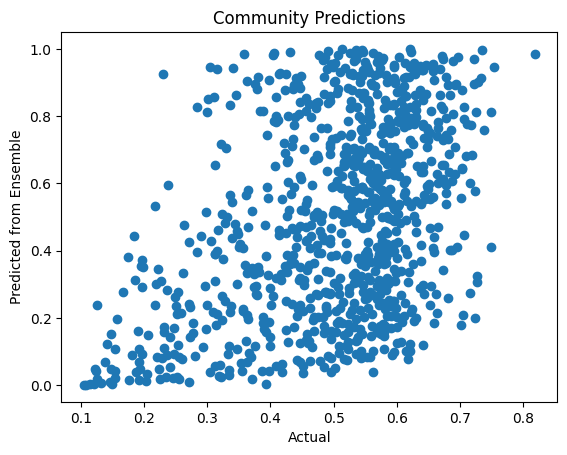

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(best_com_weights[0] * nn_preds_com + best_com_weights[1] * rf_preds_com, y_test_com)
plt.title("Community Predictions")
plt.xlabel("Actual")
plt.ylabel("Predicted from Ensemble")
plt.show()

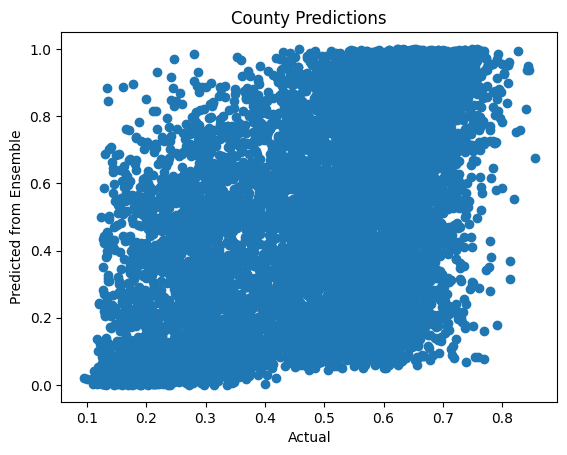

In [ ]:
plt.scatter(best_coun_weights[0] * nn_preds_coun + best_coun_weights[1] * rf_preds_coun, y_test_coun)
plt.title("County Predictions")
plt.xlabel("Actual")
plt.ylabel("Predicted from Ensemble")
plt.show()

## Other

In [ ]:
rf_states.fit(X_train_states, y_train_states)

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features=None, n_estimators=110)

In [ ]:
def get_preds(X_com, X_coun, X_states):
  nn_preds_com = model_nn_com.predict(X_com).ravel()
  rf_preds_com = model_rf_com.predict(X_com).ravel()

  # for communities
  nn_preds_coun = model_nn_coun.predict(X_coun).ravel()
  rf_preds_coun = model_rf_coun.predict(X_coun).ravel()


  preds_com = best_com_weights[0] * nn_preds_com + best_com_weights[1] * rf_preds_com
  preds_coun = best_coun_weights[0] * nn_preds_coun + best_coun_weights[1] * rf_preds_coun


  preds_states = rf_states.predict(X_states)

  return preds_com, preds_coun, preds_states

In [ ]:
val_preds_com, val_preds_coun, val_preds_states = get_preds(X_val_com, X_val_coun, X_val_states)
test_preds_com, test_preds_coun, test_preds_states = get_preds(X_test_com, X_test_coun, X_test_states)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
print(test_preds_com.shape)
print(test_preds_coun.shape)
print(test_preds_states.shape)

(943,)
(9433,)
(16,)


## method 1: weighting using RMSE

In [ ]:
# 2. Calculate RMSE for each level
rmse_com = np.sqrt(mean_squared_error(y_val_com, val_preds_com))
rmse_coun = np.sqrt(mean_squared_error(y_val_coun, val_preds_coun))
rmse_states = np.sqrt(mean_squared_error(y_val_states, val_preds_states))

w1 = 1 / rmse_com  # Community weight
w2 = 1 / rmse_coun  # County weight
w3 = 1 / rmse_states  # State weight

total = w1 + w2 + w3
w1, w2, w3 = w1/total, w2/total, w3/total

print(f"Optimal weights - Community: {w1:.4f}, County: {w2:.4f}, State: {w3:.4f}")

Optimal weights - Community: 0.3386, County: 0.3476, State: 0.3139


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

test_preds_com, test_preds_coun, test_preds_states = get_preds(X_test_com, X_test_coun, X_test_states)


print("Individual Test RMSE:")
print(f"- Community level: {np.sqrt(mean_squared_error(y_test_com, test_preds_com)):.4f}")
print(f"- County level: {np.sqrt(mean_squared_error(y_test_coun, test_preds_coun)):.4f}")
print(f"- State level: {np.sqrt(mean_squared_error(y_test_states, test_preds_states)):.4f}")

# 3. Create aligned evaluation for locations that exist at multiple levels
def get_common_locations(community_ids, county_ids, state_ids):
    """Find locations that exist at all three levels"""
    # Convert all to strings for consistent comparison if needed
    community_set = set(str(x) for x in community_ids)
    county_set = set(str(x) for x in county_ids)
    state_set = set(str(x) for x in state_ids)

    return community_set & county_set & state_set

common_locs = get_common_locations(y_test_com.index, y_test_coun.index, y_test_states.index)
print("common_locs: ", common_locs)

if len(common_locs) > 0:
    print(f"\nFound {len(common_locs)} locations common to all levels")

    # Get indices for these common locations
    com_idx = [i for i, x in enumerate(y_test_com.index) if str(x) in common_locs]
    coun_idx = [i for i, x in enumerate(y_test_coun.index) if str(x) in common_locs]
    state_idx = [i for i, x in enumerate(y_test_states.index) if str(x) in common_locs]

    # Get aligned predictions and true values
    aligned_com_pred = test_preds_com[com_idx]
    aligned_coun_pred = test_preds_coun[coun_idx]
    aligned_state_pred = test_preds_states[state_idx]
    aligned_true = y_test_com.iloc[com_idx]  # Using community-level as most granular truth

    combined_pred = (w1*aligned_com_pred + w2*aligned_coun_pred + w3*aligned_state_pred)

    # Evaluate
    combined_rmse = np.sqrt(mean_squared_error(aligned_true, combined_pred))
    print(f"Combined weighted RMSE: {combined_rmse:.4f}")
else:
    print("\nNo locations common to all three levels - evaluating county+state only")

    # Find locations common to county and state levels
    county_state_locs = set(str(x) for x in y_test_coun.index) & set(str(x) for x in y_test_states.index)
    if len(county_state_locs) > 0:
        coun_idx = [i for i, x in enumerate(y_test_coun.index) if str(x) in county_state_locs]
        state_idx = [i for i, x in enumerate(y_test_states.index) if str(x) in county_state_locs]

        aligned_coun_pred = test_preds_coun[coun_idx]
        aligned_state_pred = test_preds_states[state_idx]
        aligned_true = y_test_coun.iloc[coun_idx]  # Using county-level as truth

        w_total = w2 + w3
        combined_pred = (w2/w_total)*aligned_coun_pred + (w3/w_total)*aligned_state_pred

        combined_rmse = np.sqrt(mean_squared_error(aligned_true, combined_pred))
        print(f"County+State combined RMSE: {combined_rmse:.4f}")
    else:
        print("No overlapping locations found at any levels")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Individual Test RMSE:
- Community level: 0.2573
- County level: 0.2473
- State level: 0.2310
common_locs:  {'43', '17', '30'}

Found 3 locations common to all levels
Combined weighted RMSE: 0.1058


Comparing to baseline

In [ ]:
baseline_rmse = np.sqrt(mean_squared_error(y_test_com, [y_train_com.mean()]*len(y_test_com)))
print(f"Baseline RMSE (predicting mean): {baseline_rmse:.4f}")

Baseline RMSE (predicting mean): 0.2847


In [ ]:
improvement = (baseline_rmse - 0.1058) / baseline_rmse * 100
print(f"Combined model improves over baseline by {improvement:.1f}%")

Combined model improves over baseline by 62.8%


In [ ]:
import json
weights_data = {
    "aggregate_comm_coun_rf&nn_weights": {
        "community_level": {
            "neural_net_weight": float(best_com_weights[0]),  # Convert numpy to native float
            "random_forest_weight": float(best_com_weights[1])
        },
        "county_level": {
            "neural_net_weight": float(best_coun_weights[0]),
            "random_forest_weight": float(best_coun_weights[1])
        }
    },
    "aggregation_weights_for_all_models": {
        "community_weight": float(w1),
        "county_weight": float(w2),
        "state_weight": float(w3)
    },
    "metadata": {
        "rmse_values": {
            "community": float(rmse_com),
            "county": float(rmse_coun),
            "state": float(rmse_states)
        },
        "timestamp": pd.Timestamp.now().isoformat()
    }
}

# Save to JSON file
with open('meta_estimator_weights.json', 'w') as f:
    json.dump(weights_data, f, indent=4)

----

# Complete Code with Example

REQUIRMENTS:
1. the weights from the individual models
    * Kinjal's RF weights
    * my NN weights
2. the aggregate weights file


All of this is provided in a google drive for easy access and download.

Get the models

In [ ]:
model_nn_com = keras.saving.load_model('/content/Community_model_weights.keras')
model_nn_coun = keras.saving.load_model('/content/County_model_weights.keras')
with open('/content/rf_model_states.pkl', 'rb') as f:
    rf_states = pickle.load(f)
with open('/content/rf_model_counties.pkl', 'rb') as f:
    model_rf_coun = pickle.load(f)
with open('/content/rf_model_communities.pkl', 'rb') as f:
    model_rf_com = pickle.load(f)

Get the combined model predictions for level only

In [ ]:
def get_preds(X_com, X_coun, X_states):
    """
    Args:
      X_com: community features
      X_coun: county features
      X_states: state features
    returns:
      preds_com, preds_coun, preds_states

    This returns the prediction for the states.
    We use None to take into account that there may be a piece, or more than a piece of information
    missing.

    """
    nn_preds_com = model_nn_com.predict(X_com).ravel()
    rf_preds_com = model_rf_com.predict(X_com).ravel()

    nn_preds_coun = model_nn_coun.predict(X_coun).ravel()
    rf_preds_coun = model_rf_coun.predict(X_coun).ravel()

    preds_com = best_com_weights[0] * nn_preds_com + best_com_weights[1] * rf_preds_com
    preds_coun = best_coun_weights[0] * nn_preds_coun + best_coun_weights[1] * rf_preds_coun

    preds_states = rf_states.predict(X_states)

    return preds_com, preds_coun, preds_states

In [ ]:
weights = json.load(open('meta_estimator_weights.json'))

In [ ]:
def get_weights(weights):
  """
  Args:
    weights: json file of weights information
  returns:
    the best weights for each level saved in the file weights
  """
  weights_aggregate_community = weights["aggregate_comm_coun_rf&nn_weights"]["community_level"]
  weights_aggregate_county = weights["aggregate_comm_coun_rf&nn_weights"]["county_level"]
  weights_aggregate = weights["aggregation_weights_for_all_models"]

  best_com_weights = [weights_aggregate_community["neural_net_weight"], weights_aggregate_community["random_forest_weight"]]
  best_coun_weights = [weights_aggregate_county["neural_net_weight"], weights_aggregate_county["random_forest_weight"]]
  w1 = weights_aggregate["community_weight"]
  w2 = weights_aggregate["county_weight"]
  w3 = weights_aggregate["state_weight"]
  return best_com_weights, best_coun_weights, w1, w2, w3

In [ ]:
def get_splits(df):
    """
    Args:
      df: specific dataframe to split
    returns:
      X_train, X_val, X_test, y_train, y_val, y_test, scaler

    This is to get the scalar that was used for creation of the model for inference
    """
    required_cols = [
        'POP', 'TOTAL_BUILDINGS',
        'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE',
        'BP_NATIONAL_RANK'
    ]
    df = df[required_cols].dropna()

    X = df.drop(columns='BP_NATIONAL_RANK')
    y = df['BP_NATIONAL_RANK']

    # Train/val/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

county_df = excel_file.parse('Counties')
community_df = excel_file.parse('Communities')

X_train_com, X_val_com, X_test_com, y_train_com, y_val_com, y_test_com, scalar_com = get_splits(county_df)
X_train_coun, X_val_coun, X_test_coun, y_train_coun, y_val_coun, y_test_coun, scalar_coun = get_splits(community_df)
X_train_states, X_val_states, X_test_states, y_train_states, y_val_states, y_test_states, scalar_states = get_splits(state_df)

Get the data

In [ ]:
state_df = excel_file.parse('States')
county_df = excel_file.parse('Counties')
community_df = excel_file.parse('Communities')

Preprocessing of user input, the expectation is that:


In [ ]:
def get_location_identifiers(community, county, state):
    """
    Args:
      community: in the correct name, state format
      county: in the correct name, state format
      state: the state user lives in (postal abbreviation)
    returns:
      community_feature, state_feature, county_feature

    This is helpfer function for data preprocessor: get_user_data_and_preprocess
    """

    required_cols = [
        'POP', 'TOTAL_BUILDINGS',
        'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE'
      ]

    community_record = community_df[community_df['NAME'] == community]
    state_record = state_df[state_df['STUSPS'] == state]
    county_record = county_df[county_df['NAME'] == county]


    required_cols = [
        'POP', 'TOTAL_BUILDINGS',
        'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE'
    ]
    community_feature, state_feature, county_feature = None, None, None

    if not community_record.empty:
        community_feature = community_record[required_cols]
        community_feature = scalar_com.transform(community_feature) # apply scalar

    else:
        raise ValueError(f"Community '{community}' not found. Please check the community you to put in and try again.")

    if not state_record.empty:
        state_feature = state_record[required_cols]
        state_feature = scalar_states.transform(state_feature)  # apply scalar
    else:
        raise ValueError(f"State '{state}' not found. Please check your input and try again")

    if not county_record.empty:
        county_feature = county_record[required_cols]
        county_feature = scalar_coun.transform(county_feature)  # apply scalar
    else:
      raise ValueError(f"County '{county}' not found. Please check the community you to put in and try again")

    return community_feature, state_feature, county_feature


# this will preprocess user input to be in expected format
def get_user_data_and_preprocess(community, county, state):
  """
  Args:
    community: the name of the city or town user lives in
    county: the name of the county user lives in. SHOULD JUST BE THE NAME
    state: the state user lives in (postal abbreviation)
  returns:
    community_features, state_features, county_features

  This preprocesses user input to be in the expected format and obtained the features for inference.
  """
  community = community.rstrip()
  county = county.rstrip()
  state = state.upper()
  state = state.rstrip()

  community_full = community + ", " + state
  county_full = county + " County" + ", " + state
  print("community_full: ", community_full)
  print("county_full: ", county_full)
  print("state: ", state)
  community_features, state_features, county_features = get_location_identifiers(community_full, county_full, state)
  return community_features, state_features, county_features

In [ ]:
best_com_weights, best_coun_weights, w1, w2, w3 = get_weights(weights)

In [ ]:
def get_bp_risk_prediction(community, county, state, w1, w2, w3):
  """
  Args:
    community: the name of the city or town user lives in
    county: the name of the county user lives in. SHOULD JUST BE THE NAME
    state: the state user lives in (postal abbreviation)
    w1, w2, w3: the weights for each level
  returns:
    combined_pred: the final BP risk prediction

  The steps are as follows:
    1. obatin user input of tehir community, county, and state and extract the relavent features from the dataset. THIS IS LIMITED TO THE US.
    2. Get the predictions from each model
    3. Calculate the final risk prediction using aggregate weights found
    4. Print the final risk prediction along with the confidence level.
  """
  com_features, coun_features, state_features = get_user_data_and_preprocess(community, county, state)

  # Get predictions from each model
  preds_com, preds_coun, preds_state = get_preds(com_features, coun_features, state_features)

  # Calculate final risk (alternative method if you prefer working with raw predictions)
  if com_features is not None and coun_features is not None and state_features is not None:
      # All three levels available
      combined_pred = w1*preds_com[0] + w2*preds_coun[0] + w3*preds_state[0]
      levels_used = ['community', 'county', 'state']
      print("BP Risk Prediction for community level: ", preds_com[0])
      print("BP Risk Prediction for county level: ", preds_coun[0])
      print("BP Risk Prediction for state level: ", preds_state[0])

  elif coun_features is not None and state_features is not None:
      # County + state only
      combined_pred = w2*preds_coun[0] + w3*preds_state[0]
      levels_used = ['county', 'state']
      print("BP Risk Prediction for county level: ", preds_coun[0])
      print("BP Risk Prediction for state level: ", preds_state[0])

  elif com_features is not None and state_features is not None:
      # Community
      combined_pred = w1*preds_com[0] + w3*preds_state[0]
      levels_used = ['community']
      print("BP Risk Prediction for community level: ", preds_com[0])
  else:
      combined_pred = preds_state[0]
      levels_used = ['state']
      print("BP Risk Prediction for state level: ", preds_state)

  confidence = min(0.95, 0.7 + 0.15*len(levels_used))

  print(f"""
  BP Risk Prediction: {combined_pred:.4f}
  Confidence: {confidence:.0%}
  Levels Used: {', '.join(levels_used)}
  """)


## Some results (which can be showcased):

In [ ]:
community = "Austin"
county    = "Travis"
state     = "TX"

get_bp_risk_prediction(community, county, state, w1, w2, w3)

community_full:  Austin, TX
county_full:  Travis County, TX
state:  TX
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
BP Risk Prediction for community level:  0.6582287295898088
BP Risk Prediction for county level:  0.718572678618431
BP Risk Prediction for state level:  0.4794545454545454

  BP Risk Prediction: 0.6231
  Confidence: 95%
  Levels Used: community, county, state
  


CONTRAST IN ACTUAL:

* Austin BP: 71.3%
* Travis County BP: 65.9%
* TX BP: 78%





In [ ]:
community = "Birmingham"
county    = "Jefferson"
state     = "AL"

get_bp_risk_prediction(community, county, state, w1, w2, w3)

community_full:  Birmingham, AL
county_full:  Jefferson County, AL
state:  AL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
BP Risk Prediction for community level:  0.4596483024682998
BP Risk Prediction for county level:  0.5011071818021731
BP Risk Prediction for state level:  0.4163636363636362

  BP Risk Prediction: 0.4605
  Confidence: 95%
  Levels Used: community, county, state
  


ACTUAL:
* community: 44.90%
* county: 66.5%
* state: 56%